In [ ]:
#Importing library
import csv
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
EMBEDDING_DIM = 100
MAXLEN = 16
NUM_WORDS = 1000
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = "<OOV>"
MAX_EXAMPLES = 160000
TRAINING_SPLIT = 0.9

**Data Insight**

Dataset source : 
https://www.kaggle.com/datasets/tsqfnfl/kalimat-kasar-bahasa-indonesia?resource=download

Data that labeled 0 doesn't contain bad word, and data that labeled 1 contain bad word

In [ ]:
#Read data
df=pd.read_csv('/content/sample_data/bad_sentences.csv')
df=df.sample(frac=1)
df.head()

,sentence,contains_bad_word
432,bangsat cuti dah habis,1
52,Anjing bangsat tai doang lah,1
265,Karena si monyet sudah dimenangkan dengan kecu...,1
402,Gue sih pengennya naburin di badan bapak emak ...,1
372,Anak asu,1


In [ ]:
#Check how many data we have
df.shape

(450, 2)

In [ ]:
#Check if there is any null data
df.isnull().sum()

sentence             0
contains_bad_word    0
dtype: int64

In [ ]:
#Check how many sentences that contains bad word
bad_word = 0
good_word = 0

for i in range(len(df)) :
  if df.get("contains_bad_word")[i] == 1 :
    bad_word += 1
  else :
    good_word += 1

print("Senteces with Bad Word :", bad_word)
print("Senteces without Bad Word :", good_word)

Senteces with Bad Word : 368
Senteces without Bad Word : 82


From those, we find out that the dataset that we have is consist of 450 row with 0 null data. There also 82 sentences with bad word and 368 sentences without bad word

**Text Preparation**

Generate some setup for preparing sentences dataset before building the model

In [ ]:
#Generate stopword
def remove_stopwords(sentences):
  stopwords = []
  with open("/content/sample_data/stopwordbahasa.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
      stopwords.append(row[0])
  
  sentence = sentences.lower()
  words = sentence.split()
  no_words = [w for w in words if w not in stopwords]
  sentence = " ".join(no_words)
  
  return sentence

In [ ]:
#Testing stopwords removal function
txt = "Pada hari seNin saya ke Pasar di dEpan rMh"
remove_stopwords(txt)

'senin pasar rmh'

In [ ]:
#Seperating sentences and labels
ls = []
label = []

for i in range(len(df)) :
  text = df.get("sentence")[i]
  text = remove_stopwords(text)
  ls.append(text)

  lbl = df.get("contains_bad_word")[i]
  label.append(lbl)

In [ ]:
#Check the array of sentences and labels
print("Sentences :", ls)
print("Labels :", label)

Sentences : ['jual makanan anjing (dog food) happy dog murah harga promo', 'jual grosir makanan anjing makanan kucing petshop', "mentang-mentang anak gaul. pas dikejar anjing lari bilang 'terus gue kabur bilang wow gitu?'", 'males kalo kerja pagi trus gak ada yg nganter, anjing', 'pagi panggil anjing aja elo motornya ugal ugalan.', 'tanya, hukumya org islam pelihara anjing? byk kalangan artis yg plihara?', 'anjing... okay', 'sok geulis anjing', 'cokelat racun anjing kucing.', 'anjing jg lo ler', 'memelihara anjing n kucing nih', 'so sweet, pemain gendong anjing pengganggu laga', 'anak anjing jantan sengaja anak anjing betina menang bermain', 'anjing putih berantem', 'kesel deh pagi2 anjing ku gigit perban kakiku', 'lancau anjing.. stressnya aku..', 'mei 2007, mourinho ditangkap diduga menghalangi polisi mengkarantina anjing peliharaannya', 'pria china tewas selfie anjing laut', 'lucu, anak anjing anak kucing?', 'new jersey department of corrections melatih anjing mengendus ponsel terse

**Train Validation Split**

Splitting the dataset into set of training and validation list

In [ ]:
def train_val_split(sentences, labels, training_split):
  train_size = int(len(sentences)*training_split) #Determine split proportion

  #Define training sentences and labels
  train_sentences = sentences[:train_size]
  train_labels = labels[:train_size]

  #Define validation sentences and labels
  val_sentences = sentences[train_size:]
  val_labels = labels[train_size:]

  return train_sentences, train_labels, val_sentences, val_labels

In [ ]:
#Check the function
train_sentences, train_labels, val_sentences, val_labels = train_val_split(ls, label, TRAINING_SPLIT)

print("Training Sentences :", len(train_sentences))
print("Training Labels :", len(train_labels))
print("Validation Sentences :", len(val_sentences))
print("Validation Labels :", len(val_labels))

Training Sentences : 405
Training Labels : 405
Validation Sentences : 45
Validation Labels : 45


**Tokenization**

In [ ]:
#Build the tokenizer
def fit_tokenizer(train_sentences, oov_token) :
  tokenizer = Tokenizer(num_words=len(train_sentences), oov_token=oov_token)
  tokenizer.fit_on_texts(train_sentences)

  return tokenizer

In [ ]:
#test function
tokenizer = fit_tokenizer(train_sentences, OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 1376 words

<OOV> token included in vocabulary


In [ ]:
#Build padding and truncating
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
  sequences = tokenizer.texts_to_sequences(sentences)
  pad_trunc_sequences = pad_sequences(sequences, padding=padding, maxlen=maxlen,truncating=truncating)

  return pad_trunc_sequences

In [ ]:
train_pad_trunc_seq = seq_pad_and_trunc(train_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(val_sentences, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}")

Padded and truncated training sequences have shape: (405, 16)

Padded and truncated validation sequences have shape: (45, 16)


In [ ]:
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
train_pad_trunc_seq = np.array(train_pad_trunc_seq)
val_pad_trunc_seq = np.array(val_pad_trunc_seq)

In [166]:
def create_model(num_words, embedding_dim, maxlen):
  model = tf.keras.Sequential([tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
                               tf.keras.layers.GlobalAveragePooling1D(),
                               tf.keras.layers.Dense(24, activation='softmax'),
                               tf.keras.layers.Dense(1, activation='sigmoid')
                               ])
  
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  
  return model

In [171]:
model = create_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
history = model.fit(train_pad_trunc_seq, train_labels, epochs=200, validation_data=(val_pad_trunc_seq, val_labels))

Epoch 1/200
13/13 [==============================] - 1s 26ms/step - loss: 0.6734 - accuracy: 0.7975 - val_loss: 0.6486 - val_accuracy: 1.0000
Epoch 2/200
13/13 [==============================] - 0s 8ms/step - loss: 0.6624 - accuracy: 0.7975 - val_loss: 0.6293 - val_accuracy: 1.0000
Epoch 3/200
13/13 [==============================] - 0s 6ms/step - loss: 0.6508 - accuracy: 0.7975 - val_loss: 0.6070 - val_accuracy: 1.0000
Epoch 4/200
13/13 [==============================] - 0s 7ms/step - loss: 0.6378 - accuracy: 0.7975 - val_loss: 0.5826 - val_accuracy: 1.0000
Epoch 5/200
13/13 [==============================] - 0s 7ms/step - loss: 0.6237 - accuracy: 0.7975 - val_loss: 0.5556 - val_accuracy: 1.0000
Epoch 6/200
13/13 [==============================] - 0s 7ms/step - loss: 0.6092 - accuracy: 0.7975 - val_loss: 0.5277 - val_accuracy: 1.0000
Epoch 7/200
13/13 [==============================] - 0s 7ms/step - loss: 0.5948 - accuracy: 0.7975 - val_loss: 0.5020 - val_accuracy: 1.0000
Epoch 8/200


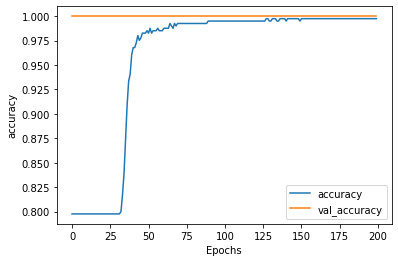

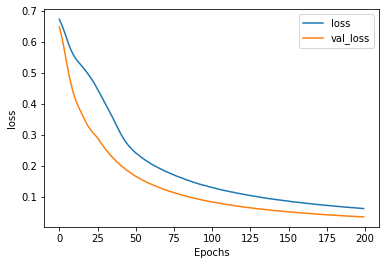

In [172]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history[f'val_{metric}'])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, f'val_{metric}'])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

**Prediction**

In [173]:
sentence = "Bangsat! Bajingan kamu Sambar Geledek"
sentence = sentence.split(".")
prediction = 0

sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=MAXLEN, padding=PADDING, truncating=TRUNCATING)
predict = model.predict(padded)

for i in range(len(predict)) :
  prediction += predict[i]

prediction = prediction/len(predict)

if prediction<0.5 :
  print("Cerita Layak Dibaca Anak")
else :
  print("Cerita Tidak Layak Dibaca Anak")

Cerita Tidak Layak Dibaca Anak


In [174]:
model.save("/content/sample_data/model.h5")

**Converting model.h5 to tflite**

In [175]:
model = tf.keras.models.load_model('/content/sample_data/model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/sample_data/model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpv47k8f7m/assets


INFO:tensorflow:Assets written to: /tmp/tmpv47k8f7m/assets


412208